# Densely Connected Convolutional Networks (DenseNets) on CIFAR10


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn as sk

In [3]:
!nvidia-smi

Sat Mar  8 13:57:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   52C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

#### Main takeways of the DenseNet paper (https://github.com/liuzhuang13/DenseNet)

_These are my notes, kindly ignore_

1. Concatenation of features (filters)

   - In contrast to ResNets, DenseNets never combine features through summation before they are passed into a layer ($L$ connections).
   - Instead, features are combined by concatenating them ($\frac{L(L+1)}{2}$ connections).

   This concatenation of feature maps from all previous is the dense connections referred to in DenseNets.

2. Dense Connections improve gradient flow (flow of information)

   - Each layer has direct access to the gradients from the loss function and the originial input signal leading to an implicit deep supervision.
   - Since each layer receives direct connections from all previous layers, the gradient signal has multiple paths to travel back to the early layers.
   - Prevents vanishing gradients.

3. Feature Reuse reduces parameters and has a regularizing effect.

   - Makes it easy to train.
   - feature reuse, reduces parameters -> reduces redundancy -> avoids memorization -> less overfitting
   - dense connections leads to an multiple feature representations leading to an ensemble effect -> improved generalization

4. Growth rate (k)

   - k controls how much new info each layer contributes. Say, k = 32, each layer adds 32 feature maps to the total

5. Dense Blocks & Transition Layers
   - Dense blocks - multiple layers connected densely
   - Transition layers - BatchNorm, 1x1 Conv (bottleneck), & Ave Pooling - reduces the feature map size

Training (for reference)

- Batch size: 64
- Epochs: 300
- Optimizer: SGD with momentum (0.9)
- Initial learning rate of 0.1, divided by 10 at 50% and 75% of total epochs
- Weight decay: 1e-4
- No dropout was used
- Data Augmentation: Mirroring (Random horizontal flip) + Shifting (Random shifts)


#### Load dataset


In [4]:
# Load data
(train_images, train_labels), (test_images, test_labels) = (
    tf.keras.datasets.cifar10.load_data()
)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [5]:
print(len(train_images))
print(len(test_images))

50000
10000


#### Display a few images


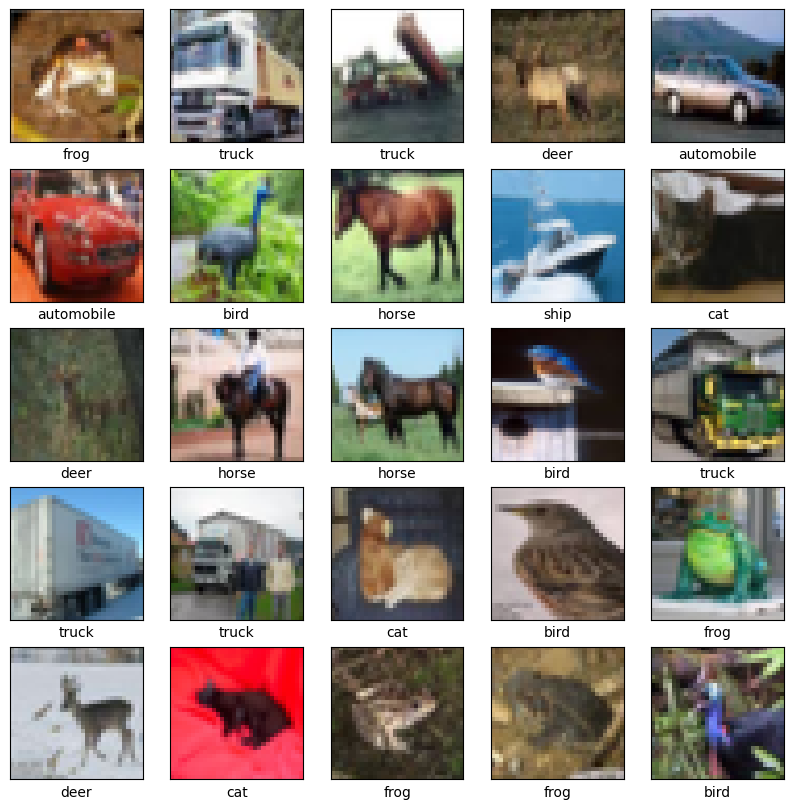

In [6]:
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [7]:
# Plot model performance
def plot_history(history):
    train_loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    train_acc = history.history["acc"]
    val_acc = history.history["val_acc"]

    plt.figure(figsize=(10, 10))

    plt.subplot(121)
    plt.plot(np.arange(1, len(train_loss) + 1), train_loss)
    plt.plot(np.arange(1, len(train_loss) + 1), val_loss)
    plt.legend(["train", "validation"])
    plt.grid()
    plt.xlabel("epoch")
    plt.ylabel("loss")

    plt.subplot(122)
    plt.plot(np.arange(1, len(train_loss) + 1), train_acc)
    plt.plot(np.arange(1, len(train_loss) + 1), val_acc)
    plt.legend(["train", "validation"])
    plt.grid()
    plt.xlabel("epoch")
    plt.ylabel("accuracy")

### Custom DenseBlock and TransitionLayer


#### DenseBlock

([For each layer]:) BatchNormalization → ReLU → 1x1 Conv2D → BatchNormalization → ReLU → 3x3 Conv2D → Concatenate


In [8]:
# Define custom DenseBlock without bottleneck layer
class DenseBlock(tf.keras.layers.Layer):
    def __init__(self, num_layers, growth_rate, bottleneck=False):
        super(DenseBlock, self).__init__()

        self.num_layers = num_layers
        self.growth_rate = growth_rate
        self.bottleneck = bottleneck

        self.layers_list = []
        for _ in range(num_layers):
            # Create a layer composition function
            layer_composition = []
            if bottleneck:
                layer_composition.append(
                    tf.keras.layers.Conv2D(
                        4 * growth_rate,
                        kernel_size=(1, 1),
                        padding="same",
                        kernel_initializer="he_uniform",
                    )
                )
                layer_composition.append(tf.keras.layers.BatchNormalization())
                layer_composition.append(tf.keras.layers.ReLU())
            layer_composition.extend(
                [
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.ReLU(),
                    tf.keras.layers.Conv2D(
                        growth_rate,
                        kernel_size=(3, 3),
                        padding="same",
                        kernel_initializer="he_uniform",
                    ),
                ]
            )
            self.layers_list.append(layer_composition)

        self.concat_layer = tf.keras.layers.Concatenate()

    def call(self, x):
        inputs = [x]  # store the feature maps

        for i in range(self.num_layers):
            layer_composition = self.layers_list[i]  # get current layer composition

            y = x

            for layer in layer_composition:
                y = layer(y)

            # Add to inputs list
            inputs.append(y)

            # concat - feature reuse
            x = self.concat_layer(inputs)

        return x

#### TransitionLayer

BatchNormalization → ReLU → 1x1 Conv2D → AveragePooling2D


In [9]:
# Transition Layer
class TransitionLayer(tf.keras.layers.Layer):
    def __init__(self, compression_factor):
        super(TransitionLayer, self).__init__()

        self.compression_factor = compression_factor  # compression_factor factor

        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.avg_pool = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=2)

    def build(self, input_shape):
        channels = int(self.compression_factor * input_shape[-1])
        self.conv = tf.keras.layers.Conv2D(channels, kernel_size=(1, 1), padding="same")
        super(TransitionLayer, self).build(input_shape)

    def call(self, x):
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.conv(x)
        out = self.avg_pool(x)
        return out

## Model Building


### Baseline Model - Growth rate, k = 12, 0.32M parameters - 71.65%


In [11]:
GROWTH_RATE = 12
COMPRESSION_FACTOR = 0.2

# Define model architecture
in_layer = tf.keras.layers.Input(shape=(32, 32, 3))  # input layer
x = tf.keras.layers.Rescaling(1.0 / 255)(in_layer)  # normalization layer
b = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same")(x)

b = DenseBlock(4, GROWTH_RATE)(b)
b = DenseBlock(4, GROWTH_RATE)(b)

b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(8, GROWTH_RATE)(b)
b = DenseBlock(8, GROWTH_RATE)(b)

b = tf.keras.layers.GlobalAveragePooling2D()(b)  # Global Average Pooling
out_layer = tf.keras.layers.Dense(10, activation="softmax")(b)

# Build model
model = tf.keras.Model(inputs=in_layer, outputs=out_layer)

model.summary()

# Compile model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block (DenseBlock)             │ (None, 32, 32, 112)         │          36,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_1 (DenseBlock)           │ (None, 32, 32, 160)         │          58,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer (TransitionLayer)   │ (None, 16, 16, 32)          │           5,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_2 (DenseBlock)           │ (None, 16, 16, 128)         │          66,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_3 (DenseBlock)           │ (None, 16, 16, 224)         │         152,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 224)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │           2,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 323,722 (1.23 MB)

 Trainable params: 317,802 (1.21 MB)

 Non-trainable params: 5,920 (23.12 KB)

In [ ]:
# Train model
history = model.fit(
    train_images,
    train_labels,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=5),
)

Epoch 1/50
633/633 ━━━━━━━━━━━━━━━━━━━━ 112s 107ms/step - acc: 0.3621 - loss: 1.7687 - val_acc: 0.4504 - val_loss: 1.5497
Epoch 2/50
633/633 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - acc: 0.5792 - loss: 1.1676 - val_acc: 0.5502 - val_loss: 1.3027
Epoch 3/50
633/633 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - acc: 0.6505 - loss: 0.9810 - val_acc: 0.3851 - val_loss: 2.6201
Epoch 4/50
633/633 ━━━━━━━━━━━━━━━━━━━━ 36s 57ms/step - acc: 0.6904 - loss: 0.8655 - val_acc: 0.5693 - val_loss: 1.2407
Epoch 5/50
633/633 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - acc: 0.7145 - loss: 0.7948 - val_acc: 0.5022 - val_loss: 1.7436
Epoch 6/50
633/633 ━━━━━━━━━━━━━━━━━━━━ 36s 57ms/step - acc: 0.7540 - loss: 0.7056 - val_acc: 0.6451 - val_loss: 0.9819
Epoch 7/50
633/633 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - acc: 0.7681 - loss: 0.6573 - val_acc: 0.5400 - val_loss: 1.7829
Epoch 8/50
633/633 ━━━━━━━━━━━━━━━━━━━━ 36s 57ms/step - acc: 0.7902 - loss: 0.6006 - val_acc: 0.4718 - val_loss: 2.0943
Epoch 9/50
633/633 ━━━━━━━━━━━━━━━━━━━

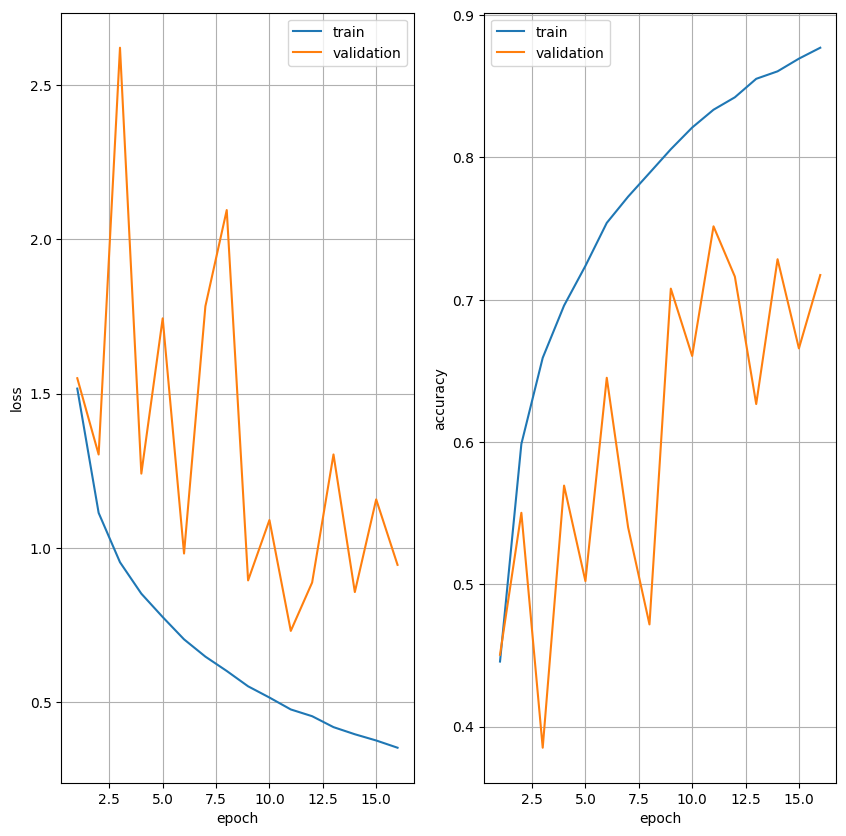

In [ ]:
plot_history(history)

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - acc: 0.7165 - loss: 0.9313


### More Transition Layers - Growth rate, k = 12, 0.18M parameters - 78.72%


In [10]:
# Define densenet model
GROWTH_RATE = 12
COMPRESSION_FACTOR = 0.5

# Define model architecture
in_layer = tf.keras.layers.Input(shape=(32, 32, 3))  # input layer
x = tf.keras.layers.Rescaling(1.0 / 255)(in_layer)  # normalization layer
b = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same")(x)

b = DenseBlock(4, GROWTH_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(4, GROWTH_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(8, GROWTH_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = tf.keras.layers.GlobalAveragePooling2D()(b)  # Global Average Pooling
out_layer = tf.keras.layers.Dense(10, activation="softmax")(b)

# Build model
model = tf.keras.Model(inputs=in_layer, outputs=out_layer)


model.summary()

# Compile model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block (DenseBlock)             │ (None, 32, 32, 112)         │          36,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer (TransitionLayer)   │ (None, 16, 16, 56)          │           6,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_1 (DenseBlock)           │ (None, 16, 16, 104)         │          33,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_1 (TransitionLayer) │ (None, 8, 8, 52)            │           5,876 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_2 (DenseBlock)           │ (None, 8, 8, 148)           │          84,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_2 (TransitionLayer) │ (None, 4, 4, 74)            │          11,618 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 74)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │             750 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 181,116 (707.48 KB)

 Trainable params: 177,636 (693.89 KB)

 Non-trainable params: 3,480 (13.59 KB)

In [11]:
# Train model
history = model.fit(
    train_images,
    train_labels,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=10),
)

Epoch 1/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 72s 61ms/step - acc: 0.4219 - loss: 1.5710 - val_acc: 0.4632 - val_loss: 1.5992
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - acc: 0.6315 - loss: 1.0260 - val_acc: 0.5356 - val_loss: 1.3985
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - acc: 0.6998 - loss: 0.8419 - val_acc: 0.5842 - val_loss: 1.2434
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - acc: 0.7438 - loss: 0.7277 - val_acc: 0.6526 - val_loss: 1.0025
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - acc: 0.7678 - loss: 0.6554 - val_acc: 0.6850 - val_loss: 0.9107
Epoch 6/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - acc: 0.7949 - loss: 0.5889 - val_acc: 0.6404 - val_loss: 1.1056
Epoch 7/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - acc: 0.8159 - loss: 0.5238 - val_acc: 0.7598 - val_loss: 0.6979
Epoch 8/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - acc: 0.8303 - loss: 0.4819 - val_acc: 0.7490 - val_loss: 0.7492
Epoch 9/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 

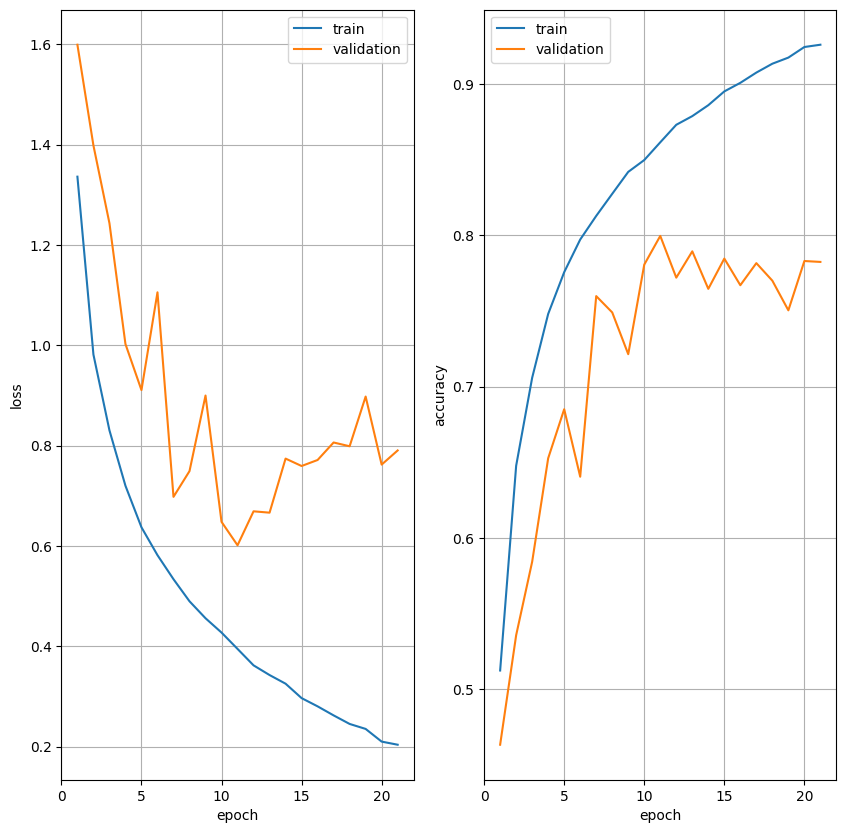

In [12]:
plot_history(history)

In [13]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - acc: 0.7872 - loss: 0.7997


## Data Augementation (model-based)


### Growth rate, k = 12, data_aug(model-based), 0.18M parameters - 78.32%


In [ ]:
GROWTH_RATE = 12
COMPRESSION_FACTOR = 0.5

#
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"), # mirroring
        tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1), # shifting
    ]
)

# Define model architecture
in_layer = tf.keras.layers.Input(shape=(32, 32, 3))  # input layer
x = tf.keras.layers.Rescaling(1.0 / 255)(in_layer)  # normalization layer

x = data_augmentation(x)  # data augmentation

b = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same")(x)

b = DenseBlock(4, GROWTH_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(4, GROWTH_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(8, GROWTH_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = tf.keras.layers.GlobalAveragePooling2D()(b)  # Global Average Pooling
out_layer = tf.keras.layers.Dense(10, activation="softmax")(b)

# Build model
model = tf.keras.Model(inputs=in_layer, outputs=out_layer)

model.summary()

# Compile model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"])

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_30 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_24 (Sequential)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_555 (Conv2D)             │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_66 (DenseBlock)     │ (None, 32, 32, 112)    │        36,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_layer_19             │ (None, 16, 16, 56)     │         6,776 │
│ (TransitionLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_67 (DenseBlock)     │ (None, 16, 16, 104)    │        33,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_layer_20             │ (None, 8, 8, 52)       │         5,876 │
│ (TransitionLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_68 (DenseBlock)     │ (None, 8, 8, 148)      │        84,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_layer_21             │ (None, 4, 4, 74)       │        11,618 │
│ (TransitionLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 74)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           750 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 181,116 (707.48 KB)

 Trainable params: 177,636 (693.89 KB)

 Non-trainable params: 3,480 (13.59 KB)

In [ ]:
# Train model
history = model.fit(
    train_images,
    train_labels,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=5),
)

Epoch 1/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 246s 343ms/step - acc: 0.3866 - loss: 1.6598 - val_acc: 0.3382 - val_loss: 2.7393
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 239s 339ms/step - acc: 0.5953 - loss: 1.1236 - val_acc: 0.6148 - val_loss: 1.1500
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 240s 341ms/step - acc: 0.6753 - loss: 0.9233 - val_acc: 0.5018 - val_loss: 1.5970
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 242s 344ms/step - acc: 0.7202 - loss: 0.7918 - val_acc: 0.6476 - val_loss: 1.0898
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 241s 342ms/step - acc: 0.7465 - loss: 0.7302 - val_acc: 0.7470 - val_loss: 0.7348
Epoch 6/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 241s 342ms/step - acc: 0.7714 - loss: 0.6569 - val_acc: 0.6834 - val_loss: 0.9670
Epoch 7/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 242s 344ms/step - acc: 0.7831 - loss: 0.6219 - val_acc: 0.7518 - val_loss: 0.7611
Epoch 8/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 240s 341ms/step - acc: 0.7976 - loss: 0.5777 - val_acc: 0.7372 - val_loss: 0.8223
Epoch 9/50
704/704 ━━━━━

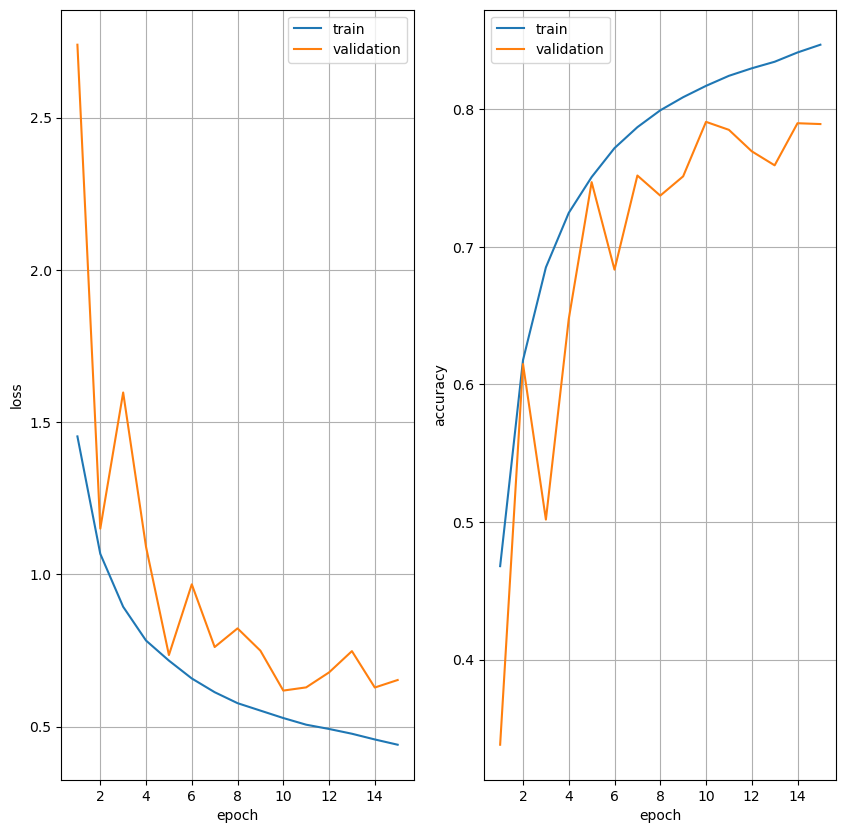

In [ ]:
plot_history(history)

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - acc: 0.7835 - loss: 0.6861


### Growth rate, k = 12, data_aug(model-based), 1.0M parameters - 81.76%


In [ ]:
GROWTH_RATE = 12
COMPRESSION_FACTOR = 0.5

data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    ]
)

# Define model architecture
in_layer = tf.keras.layers.Input(shape=(32, 32, 3))  # input layer
x = tf.keras.layers.Rescaling(1.0 / 255)(in_layer)  # normalization layer

x = data_augmentation(x)  # data augmentation

b = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same")(x)

b = DenseBlock(6, GROWTH_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(12, GROWTH_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(24, GROWTH_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = tf.keras.layers.GlobalAveragePooling2D()(b)  # Global Average Pooling
out_layer = tf.keras.layers.Dense(10, activation="softmax")(b)

# Build model
model = tf.keras.Model(inputs=in_layer, outputs=out_layer)

model.summary()

# Compile model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"])

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_10 (Rescaling)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_457 (Conv2D)             │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_29 (DenseBlock)     │ (None, 32, 32, 136)    │        63,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_layer_25             │ (None, 16, 16, 68)     │         9,860 │
│ (TransitionLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_30 (DenseBlock)     │ (None, 16, 16, 212)    │       180,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_layer_26             │ (None, 8, 8, 106)      │        23,426 │
│ (TransitionLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_31 (DenseBlock)     │ (None, 8, 8, 394)      │       656,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_layer_27             │ (None, 4, 4, 197)      │        79,391 │
│ (TransitionLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 197)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,980 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,016,089 (3.88 MB)

 Trainable params: 998,549 (3.81 MB)

 Non-trainable params: 17,540 (68.52 KB)

In [ ]:
# Train model
history = model.fit(
    train_images,
    train_labels,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=5),
)

Epoch 1/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 675s 941ms/step - acc: 0.3954 - loss: 1.6601 - val_acc: 0.4732 - val_loss: 1.4343
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 656s 932ms/step - acc: 0.6270 - loss: 1.0401 - val_acc: 0.6084 - val_loss: 1.1599
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 656s 932ms/step - acc: 0.7051 - loss: 0.8235 - val_acc: 0.4688 - val_loss: 2.4443
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 662s 941ms/step - acc: 0.7547 - loss: 0.6982 - val_acc: 0.7044 - val_loss: 0.9235
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 659s 936ms/step - acc: 0.7829 - loss: 0.6230 - val_acc: 0.6926 - val_loss: 0.9840
Epoch 6/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 669s 950ms/step - acc: 0.8055 - loss: 0.5635 - val_acc: 0.7768 - val_loss: 0.6498
Epoch 7/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 668s 949ms/step - acc: 0.8232 - loss: 0.5133 - val_acc: 0.7246 - val_loss: 0.8541
Epoch 8/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 659s 936ms/step - acc: 0.8421 - loss: 0.4623 - val_acc: 0.7982 - val_loss: 0.6253
Epoch 9/50
704/704 ━━━━━

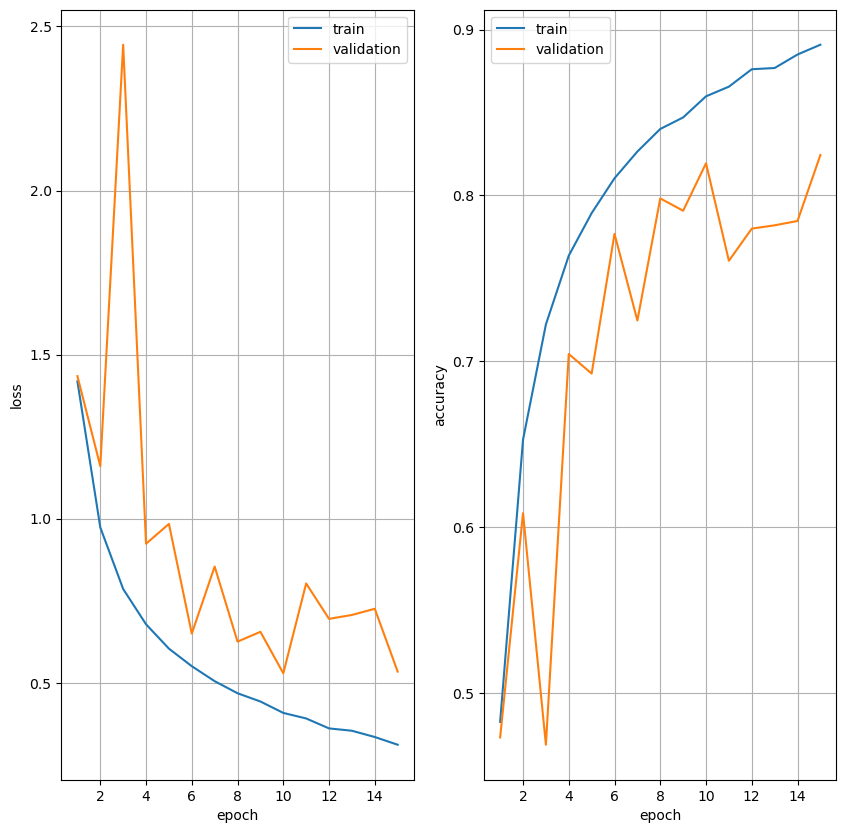

In [ ]:
plot_history(history)

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 138ms/step - acc: 0.8176 - loss: 0.5489


We notice that an increase in parameters by about 5.5 times results to only a marginal increase in accuracy. (Still subject to stochastic)


## Use Bottleneck layers


### Growth rate, k = 12, bottlenecks, data_aug(model-based), 0.7M parameters - 87.59%


In [ ]:
GROWTH_RATE = 12
COMPRESSION_FACTOR = 0.5

data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    ]
)

# Define model architecture
in_layer = tf.keras.layers.Input(shape=(32, 32, 3))  # input layer
x = tf.keras.layers.Rescaling(1.0 / 255)(in_layer)  # normalization layer

x = data_augmentation(x)  # data augmentation

b = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same")(x)

b = DenseBlock(6, GROWTH_RATE, bottleneck=True)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(12, GROWTH_RATE, bottleneck=True)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(24, GROWTH_RATE, bottleneck=True)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = tf.keras.layers.GlobalAveragePooling2D()(b)  # Global Average Pooling
out_layer = tf.keras.layers.Dense(10, activation="softmax")(b)

# Build model
model = tf.keras.Model(inputs=in_layer, outputs=out_layer)

model.summary()

# Compile model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"])

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_4 (DenseBlock)           │ (None, 32, 32, 136)         │          60,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_1 (TransitionLayer) │ (None, 16, 16, 68)          │           9,860 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_5 (DenseBlock)           │ (None, 16, 16, 212)         │         144,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_2 (TransitionLayer) │ (None, 8, 8, 106)           │          23,426 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_6 (DenseBlock)           │ (None, 8, 8, 394)           │         416,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_3 (TransitionLayer) │ (None, 4, 4, 197)           │          79,391 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 197)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,980 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 738,169 (2.82 MB)

 Trainable params: 728,621 (2.78 MB)

 Non-trainable params: 9,548 (37.30 KB)

In [ ]:
# Train model
history = model.fit(
    train_images,
    train_labels,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
)

Epoch 1/50
633/633 ━━━━━━━━━━━━━━━━━━━━ 175s 174ms/step - acc: 0.3755 - loss: 1.7055 - val_acc: 0.4580 - val_loss: 1.5380
Epoch 2/50
633/633 ━━━━━━━━━━━━━━━━━━━━ 103s 163ms/step - acc: 0.6245 - loss: 1.0526 - val_acc: 0.6309 - val_loss: 1.0509
Epoch 3/50
633/633 ━━━━━━━━━━━━━━━━━━━━ 105s 165ms/step - acc: 0.7121 - loss: 0.8111 - val_acc: 0.6918 - val_loss: 0.9197
Epoch 4/50
633/633 ━━━━━━━━━━━━━━━━━━━━ 103s 163ms/step - acc: 0.7669 - loss: 0.6728 - val_acc: 0.7356 - val_loss: 0.7603
Epoch 5/50
633/633 ━━━━━━━━━━━━━━━━━━━━ 102s 160ms/step - acc: 0.7931 - loss: 0.5920 - val_acc: 0.7649 - val_loss: 0.6829
Epoch 6/50
633/633 ━━━━━━━━━━━━━━━━━━━━ 101s 160ms/step - acc: 0.8217 - loss: 0.5184 - val_acc: 0.7604 - val_loss: 0.6883
Epoch 7/50
633/633 ━━━━━━━━━━━━━━━━━━━━ 101s 160ms/step - acc: 0.8362 - loss: 0.4730 - val_acc: 0.7398 - val_loss: 0.8029
Epoch 8/50
633/633 ━━━━━━━━━━━━━━━━━━━━ 103s 162ms/step - acc: 0.8455 - loss: 0.4507 - val_acc: 0.8136 - val_loss: 0.5355
Epoch 9/50
633/633 ━━━━━


313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - acc: 0.8759 - loss: 0.3856


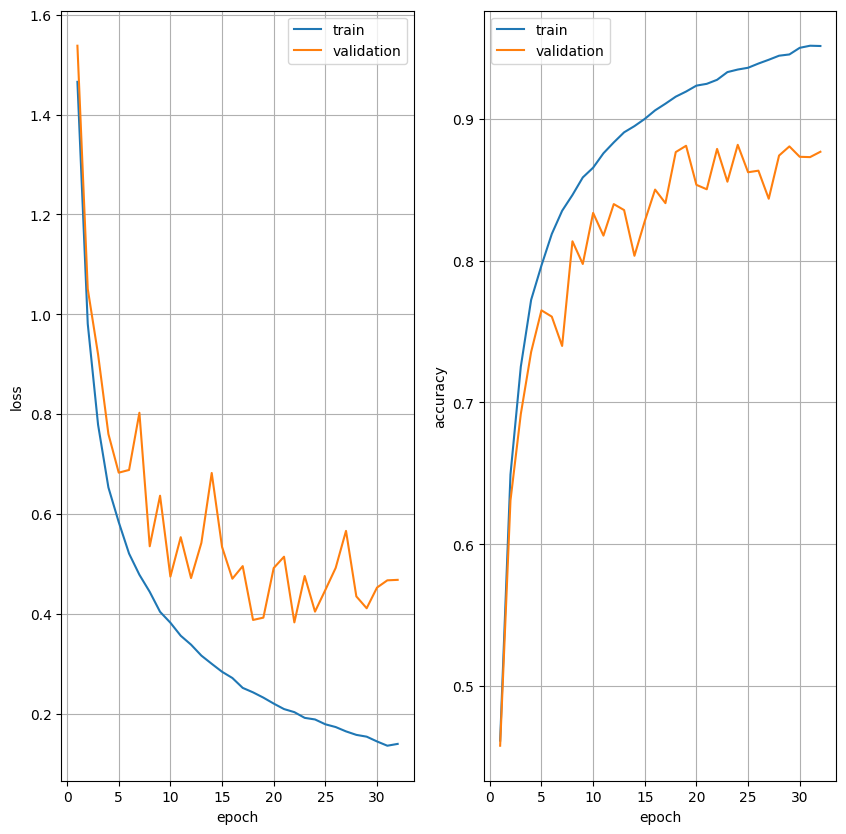

In [ ]:
plot_history(history)
print()
test_loss, test_acc = model.evaluate(test_images, test_labels)

## Add Dropout layers


### Growth rate, k = 12, dropout, data_aug(model-based), 0.18M parameters - 74.59%


In [ ]:
GROWTH_RATE = 12
COMPRESSION_FACTOR = 0.5
DROPOUT_RATE = 0.2

data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    ]
)

# Define model architecture
in_layer = tf.keras.layers.Input(shape=(32, 32, 3))  # input layer
x = tf.keras.layers.Rescaling(1.0 / 255)(in_layer)  # normalization layer

b = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same")(x)

b = DenseBlock(4, GROWTH_RATE)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(4, GROWTH_RATE)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(8, GROWTH_RATE)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = tf.keras.layers.GlobalAveragePooling2D()(b)  # Global Average Pooling
out_layer = tf.keras.layers.Dense(10, activation="softmax")(b)

# Build model
model = tf.keras.Model(inputs=in_layer, outputs=out_layer)

model.summary()

# Compile model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"])

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_35 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_626 (Conv2D)             │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_73 (DenseBlock)     │ (None, 32, 32, 112)    │        36,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 112)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_layer_25             │ (None, 16, 16, 56)     │         6,776 │
│ (TransitionLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_74 (DenseBlock)     │ (None, 16, 16, 104)    │        33,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 104)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_layer_26             │ (None, 8, 8, 52)       │         5,876 │
│ (TransitionLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_75 (DenseBlock)     │ (None, 8, 8, 148)      │        84,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 148)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_layer_27             │ (None, 4, 4, 74)       │        11,618 │
│ (TransitionLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_13     │ (None, 74)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │           750 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 181,116 (707.48 KB)

 Trainable params: 177,636 (693.89 KB)

 Non-trainable params: 3,480 (13.59 KB)

In [ ]:
# Train model
history = model.fit(
    train_images,
    train_labels,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
)

Epoch 1/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 248s 345ms/step - acc: 0.3864 - loss: 1.6482 - val_acc: 0.3854 - val_loss: 1.8985
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 233s 330ms/step - acc: 0.6072 - loss: 1.0931 - val_acc: 0.5720 - val_loss: 1.2614
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 241s 342ms/step - acc: 0.6716 - loss: 0.9186 - val_acc: 0.6178 - val_loss: 1.1878
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 235s 333ms/step - acc: 0.7083 - loss: 0.8181 - val_acc: 0.5670 - val_loss: 1.4242
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 243s 345ms/step - acc: 0.7473 - loss: 0.7211 - val_acc: 0.6898 - val_loss: 0.9020
Epoch 6/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 237s 336ms/step - acc: 0.7685 - loss: 0.6598 - val_acc: 0.7304 - val_loss: 0.7809
Epoch 7/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 242s 344ms/step - acc: 0.7851 - loss: 0.6169 - val_acc: 0.5994 - val_loss: 1.4780
Epoch 8/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 231s 329ms/step - acc: 0.7982 - loss: 0.5714 - val_acc: 0.5810 - val_loss: 1.5672
Epoch 9/50
704/704 ━━━━━

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - acc: 0.7797 - loss: 0.7372


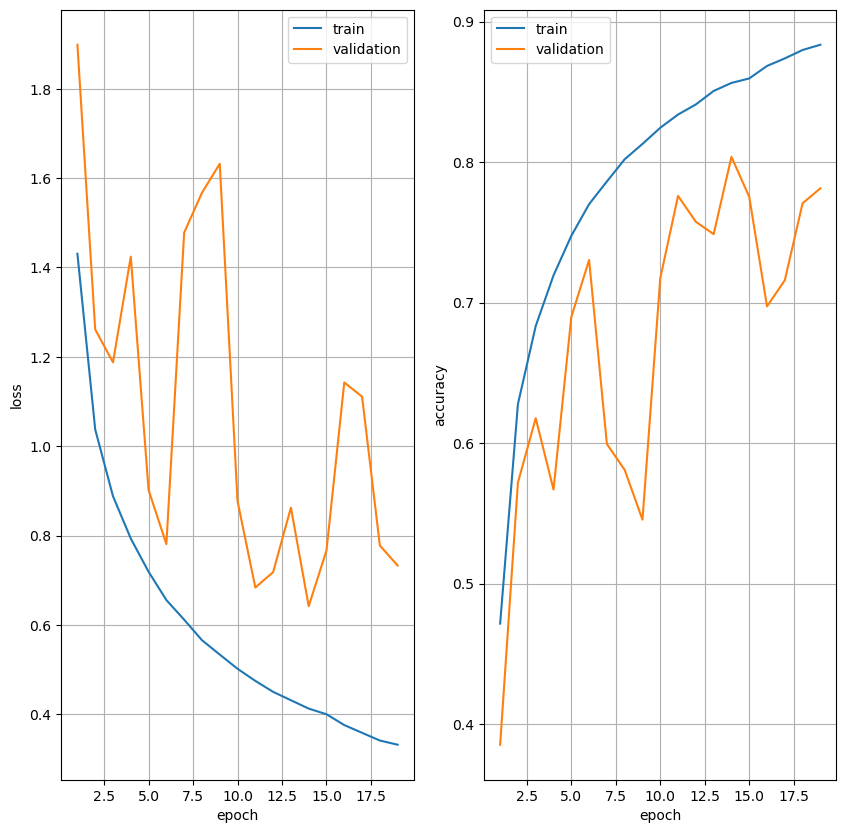

In [ ]:
plot_history(history)

### Growth rate, k = 12, bottlenecks, data_aug(model-based), 0.7M parameters - 87.53%


In [ ]:
GROWTH_RATE = 12
COMPRESSION_FACTOR = 0.5
DROPOUT_RATE = 0.2

data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    ]
)

# Define model architecture
in_layer = tf.keras.layers.Input(shape=(32, 32, 3))  # input layer
x = tf.keras.layers.Rescaling(1.0 / 255)(in_layer)  # normalization layer

x = data_augmentation(x)  # data augmentation

b = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same")(x)

b = DenseBlock(6, GROWTH_RATE, bottleneck=True)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(12, GROWTH_RATE, bottleneck=True)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(24, GROWTH_RATE, bottleneck=True)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = tf.keras.layers.GlobalAveragePooling2D()(b)  # Global Average Pooling
out_layer = tf.keras.layers.Dense(10, activation="softmax")(b)

# Build model
model = tf.keras.Model(inputs=in_layer, outputs=out_layer)

model.summary()

# Compile model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"])

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_114 (Conv2D)                  │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_7 (DenseBlock)           │ (None, 32, 32, 136)         │          60,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 136)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_4 (TransitionLayer) │ (None, 16, 16, 68)          │           9,860 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_8 (DenseBlock)           │ (None, 16, 16, 212)         │         144,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 212)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_5 (TransitionLayer) │ (None, 8, 8, 106)           │          23,426 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_9 (DenseBlock)           │ (None, 8, 8, 394)           │         416,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 394)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_6 (TransitionLayer) │ (None, 4, 4, 197)           │          79,391 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 197)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,980 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 738,169 (2.82 MB)

 Trainable params: 728,621 (2.78 MB)

 Non-trainable params: 9,548 (37.30 KB)

In [ ]:
# Train model
history = model.fit(
    train_images,
    train_labels,
    epochs=70,
    batch_size=64,
    validation_split=0.1,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
)

Epoch 1/70
633/633 ━━━━━━━━━━━━━━━━━━━━ 168s 172ms/step - acc: 0.3659 - loss: 1.6993 - val_acc: 0.4116 - val_loss: 1.9625
Epoch 2/70
633/633 ━━━━━━━━━━━━━━━━━━━━ 105s 166ms/step - acc: 0.6091 - loss: 1.0903 - val_acc: 0.5496 - val_loss: 1.6226
Epoch 3/70
633/633 ━━━━━━━━━━━━━━━━━━━━ 106s 167ms/step - acc: 0.7039 - loss: 0.8472 - val_acc: 0.6911 - val_loss: 0.9469
Epoch 4/70
633/633 ━━━━━━━━━━━━━━━━━━━━ 105s 166ms/step - acc: 0.7545 - loss: 0.7083 - val_acc: 0.7144 - val_loss: 0.9510
Epoch 5/70
633/633 ━━━━━━━━━━━━━━━━━━━━ 105s 165ms/step - acc: 0.7841 - loss: 0.6341 - val_acc: 0.7622 - val_loss: 0.7317
Epoch 6/70
633/633 ━━━━━━━━━━━━━━━━━━━━ 104s 165ms/step - acc: 0.8033 - loss: 0.5646 - val_acc: 0.7364 - val_loss: 0.8505
Epoch 7/70
633/633 ━━━━━━━━━━━━━━━━━━━━ 104s 165ms/step - acc: 0.8212 - loss: 0.5093 - val_acc: 0.7227 - val_loss: 0.8937
Epoch 8/70
633/633 ━━━━━━━━━━━━━━━━━━━━ 105s 165ms/step - acc: 0.8341 - loss: 0.4746 - val_acc: 0.7751 - val_loss: 0.7131
Epoch 9/70
633/633 ━━━━━


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - acc: 0.8753 - loss: 0.4164


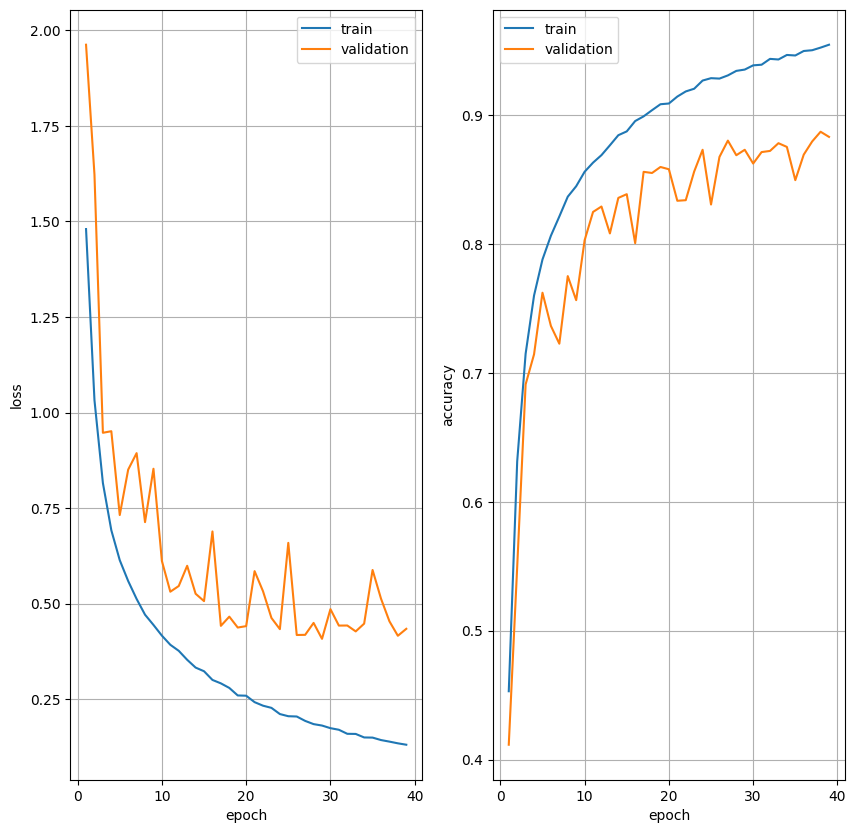

In [ ]:
plot_history(history)
print()
test_loss, test_acc = model.evaluate(test_images, test_labels)

## Wider DenseNets


### Growth rate, k = 24, bottlenecks, data_aug(model-based), 2.7M parameters - 89.8%


In [ ]:
GROWTH_RATE = 24
COMPRESSION_FACTOR = 0.5

data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    ]
)

# Define model architecture
in_layer = tf.keras.layers.Input(shape=(32, 32, 3))  # input layer
x = tf.keras.layers.Rescaling(1.0 / 255)(in_layer)  # normalization layer

x = data_augmentation(x)  # data augmentation

b = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same")(x)

b = DenseBlock(6, GROWTH_RATE, bottleneck=True)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(12, GROWTH_RATE, bottleneck=True)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(24, GROWTH_RATE, bottleneck=True)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = tf.keras.layers.GlobalAveragePooling2D()(b)  # Global Average Pooling
out_layer = tf.keras.layers.Dense(10, activation="softmax")(b)

# Build model
model = tf.keras.Model(inputs=in_layer, outputs=out_layer)

model.summary()

# Compile model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"])

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_3 (Rescaling)              │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_202 (Conv2D)                  │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_10 (DenseBlock)          │ (None, 32, 32, 208)         │         201,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_7 (TransitionLayer) │ (None, 16, 16, 104)         │          22,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_11 (DenseBlock)          │ (None, 16, 16, 392)         │         531,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_8 (TransitionLayer) │ (None, 8, 8, 196)           │          78,596 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_12 (DenseBlock)          │ (None, 8, 8, 772)           │       1,606,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_9 (TransitionLayer) │ (None, 4, 4, 386)           │         301,466 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 386)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           3,870 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,747,284 (10.48 MB)

 Trainable params: 2,728,412 (10.41 MB)

 Non-trainable params: 18,872 (73.72 KB)

In [ ]:
# Train model
history = model.fit(
    train_images,
    train_labels,
    epochs=100,
    batch_size=64,
    validation_split=0.1,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
)

Epoch 1/100
633/633 ━━━━━━━━━━━━━━━━━━━━ 235s 267ms/step - acc: 0.3523 - loss: 1.8158 - val_acc: 0.4944 - val_loss: 1.4381
Epoch 2/100
633/633 ━━━━━━━━━━━━━━━━━━━━ 162s 255ms/step - acc: 0.6015 - loss: 1.1163 - val_acc: 0.5973 - val_loss: 1.2380
Epoch 3/100
633/633 ━━━━━━━━━━━━━━━━━━━━ 162s 256ms/step - acc: 0.6905 - loss: 0.8636 - val_acc: 0.6296 - val_loss: 1.1793
Epoch 4/100
633/633 ━━━━━━━━━━━━━━━━━━━━ 162s 255ms/step - acc: 0.7537 - loss: 0.7041 - val_acc: 0.5947 - val_loss: 1.3425
Epoch 5/100
633/633 ━━━━━━━━━━━━━━━━━━━━ 162s 256ms/step - acc: 0.7891 - loss: 0.6088 - val_acc: 0.6531 - val_loss: 1.1060
Epoch 6/100
633/633 ━━━━━━━━━━━━━━━━━━━━ 162s 256ms/step - acc: 0.8156 - loss: 0.5366 - val_acc: 0.7747 - val_loss: 0.6952
Epoch 7/100
633/633 ━━━━━━━━━━━━━━━━━━━━ 162s 255ms/step - acc: 0.8357 - loss: 0.4795 - val_acc: 0.7622 - val_loss: 0.7372
Epoch 8/100
633/633 ━━━━━━━━━━━━━━━━━━━━ 162s 256ms/step - acc: 0.8483 - loss: 0.4418 - val_acc: 0.7998 - val_loss: 0.5803
Epoch 9/100
633/


313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - acc: 0.8979 - loss: 0.3903


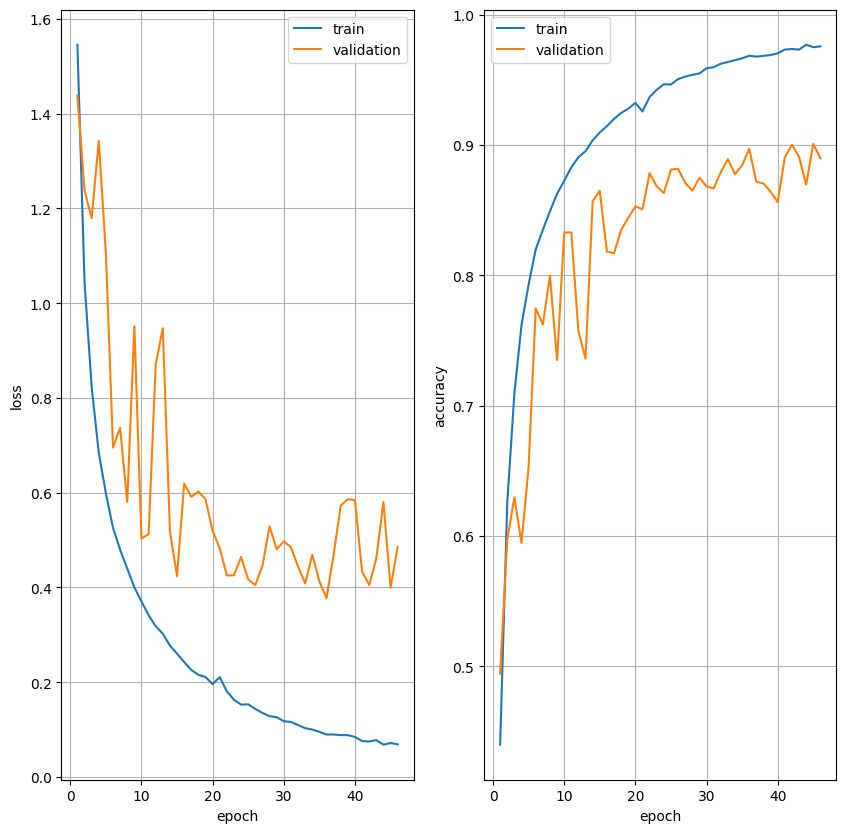

In [ ]:
plot_history(history)
print()
test_loss, test_acc = model.evaluate(test_images, test_labels)

### Growth rate, k = 24, Dropout, data_aug(model-based), 1.67M parameters - 85.29%


In [11]:
GROWTH_RATE = 24
COMPRESSION_FACTOR = 0.5
DROPOUT_RATE = 0.2

data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    ]
)

# Define model architecture
in_layer = tf.keras.layers.Input(shape=(32, 32, 3))  # input layer
x = tf.keras.layers.Rescaling(1.0 / 255)(in_layer)  # normalization layer

x = data_augmentation(x)  # data augmentation

b = tf.keras.layers.Conv2D(12, kernel_size=(3, 3), padding="same")(x)

b = DenseBlock(6, GROWTH_RATE)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(12, GROWTH_RATE)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(12, GROWTH_RATE)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)


b = tf.keras.layers.GlobalAveragePooling2D()(b)  # Global Average Pooling
out_layer = tf.keras.layers.Dense(10, activation="softmax")(b)

# Build model
model = tf.keras.Model(inputs=in_layer, outputs=out_layer)

model.summary()

# Compile model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 12)          │             336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block (DenseBlock)             │ (None, 32, 32, 156)         │          95,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 156)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer (TransitionLayer)   │ (None, 16, 16, 78)          │          12,870 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_1 (DenseBlock)           │ (None, 16, 16, 366)         │         554,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 366)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_1 (TransitionLayer) │ (None, 8, 8, 183)           │          68,625 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_2 (DenseBlock)           │ (None, 8, 8, 471)           │         831,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 471)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_2 (TransitionLayer) │ (None, 4, 4, 235)           │         112,804 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 235)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │           2,360 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,678,755 (6.40 MB)

 Trainable params: 1,663,305 (6.35 MB)

 Non-trainable params: 15,450 (60.35 KB)

In [12]:
# Train model
history = model.fit(
    train_images,
    train_labels,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
)

Epoch 1/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 147s 167ms/step - acc: 0.3914 - loss: 1.6732 - val_acc: 0.4214 - val_loss: 2.2617
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 116s 164ms/step - acc: 0.6266 - loss: 1.0438 - val_acc: 0.5548 - val_loss: 1.4264
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 115s 164ms/step - acc: 0.6984 - loss: 0.8617 - val_acc: 0.6514 - val_loss: 1.1679
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 142s 164ms/step - acc: 0.7450 - loss: 0.7332 - val_acc: 0.6602 - val_loss: 1.1925
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 142s 164ms/step - acc: 0.7721 - loss: 0.6527 - val_acc: 0.6768 - val_loss: 1.0228
Epoch 6/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 116s 164ms/step - acc: 0.8003 - loss: 0.5830 - val_acc: 0.7858 - val_loss: 0.6618
Epoch 7/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 142s 164ms/step - acc: 0.8171 - loss: 0.5355 - val_acc: 0.7314 - val_loss: 0.8595
Epoch 8/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 142s 164ms/step - acc: 0.8306 - loss: 0.4882 - val_acc: 0.7720 - val_loss: 0.7393
Epoch 9/50
704/704 ━━━━━

In [13]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - acc: 0.8529 - loss: 0.4676


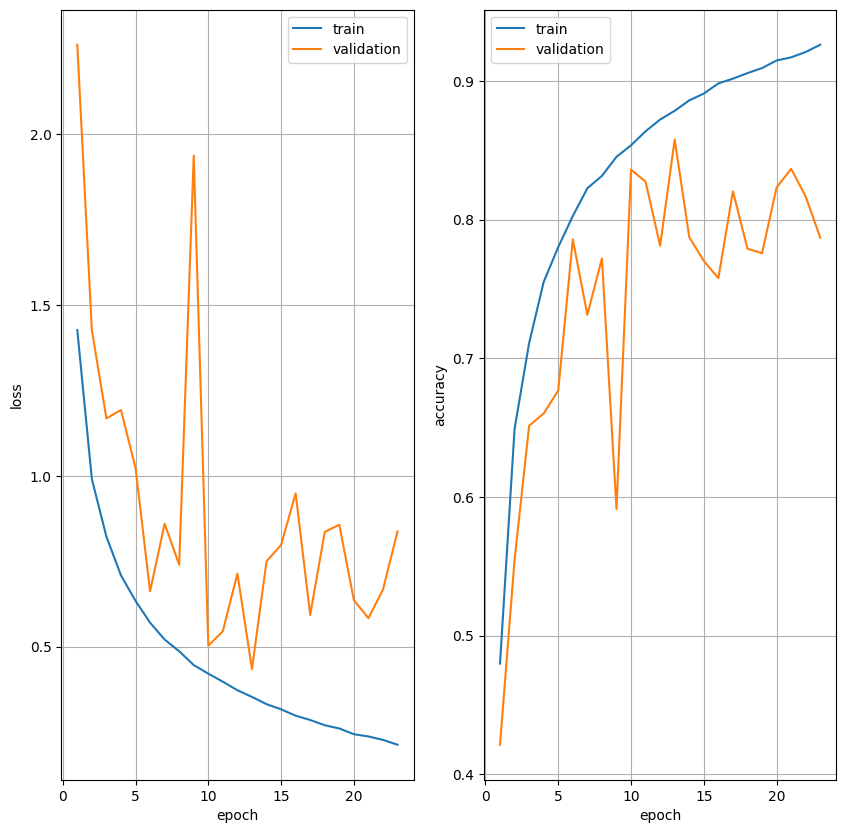

In [14]:
plot_history(history)

## Data augmentation (Pipeline-based) [experiments]


In [15]:
# train and validation sets split
train_images, val_images, train_labels, val_labels = (
    sk.model_selection.train_test_split(
        train_images, train_labels, test_size=0.1, random_state=42
    )
)


# data augmentation layers
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"), # mirroring
        tf.keras.layers.RandomTranslation(0.1, 0.1), # shifting
    ],
    name="data_augmentation",
)


# preprocess data augmentation
def preprocess_data_augmentation(x, y):
    x = data_augmentation(x, training=True)
    return x, y


BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

# train set
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = (
    train_ds.shuffle(buffer_size=5000)
    .batch(BATCH_SIZE)
    .map(preprocess_data_augmentation, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)

# validation set
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# test set
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

### Growth rate, k = 12, data_aug(pipeline-based), 1.3M parameters - 88.65%


In [16]:
GROWTH_RATE = 12
COMPRESSION_FACTOR = 0.5
DROPOUT_RATE = 0.2

# Define model architecture
in_layer = tf.keras.layers.Input(shape=(32, 32, 3))  # input layer
x = tf.keras.layers.Rescaling(1.0 / 255)(in_layer)  # normalization layer

b = tf.keras.layers.Conv2D(12, kernel_size=(3, 3), padding="same")(x)

b = DenseBlock(6, GROWTH_RATE)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(12, GROWTH_RATE)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(24, GROWTH_RATE)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(12, GROWTH_RATE)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = tf.keras.layers.GlobalAveragePooling2D()(b)  # Global Average Pooling
out_layer = tf.keras.layers.Dense(10, activation="softmax")(b)

# Build model
model = tf.keras.Model(inputs=in_layer, outputs=out_layer)

model.summary()

# Compile model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"])

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 32, 32, 12)          │             336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_3 (DenseBlock)           │ (None, 32, 32, 84)          │          28,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32, 32, 84)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_3 (TransitionLayer) │ (None, 16, 16, 42)          │           3,906 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_4 (DenseBlock)           │ (None, 16, 16, 186)         │         145,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16, 16, 186)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_4 (TransitionLayer) │ (None, 8, 8, 93)            │          18,135 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_5 (DenseBlock)           │ (None, 8, 8, 381)           │         621,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 8, 8, 381)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_5 (TransitionLayer) │ (None, 4, 4, 190)           │          74,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_6 (DenseBlock)           │ (None, 4, 4, 334)           │         344,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 4, 4, 334)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_6 (TransitionLayer) │ (None, 2, 2, 167)           │          57,281 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 167)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,680 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,294,458 (4.94 MB)

 Trainable params: 1,272,160 (4.85 MB)

 Non-trainable params: 22,298 (87.10 KB)

In [17]:
# Train model
history = model.fit(
    train_ds,
    epochs=50,
    batch_size=64,
    validation_data=val_ds,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
)

Epoch 1/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 220s 174ms/step - acc: 0.3911 - loss: 1.6527 - val_acc: 0.5676 - val_loss: 1.2519
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 49s 69ms/step - acc: 0.6258 - loss: 1.0545 - val_acc: 0.5896 - val_loss: 1.3522
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 47s 67ms/step - acc: 0.7083 - loss: 0.8367 - val_acc: 0.6972 - val_loss: 0.9234
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 88s 76ms/step - acc: 0.7428 - loss: 0.7293 - val_acc: 0.7084 - val_loss: 0.8698
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 82s 76ms/step - acc: 0.7772 - loss: 0.6399 - val_acc: 0.6840 - val_loss: 1.0071
Epoch 6/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 50s 71ms/step - acc: 0.7957 - loss: 0.5968 - val_acc: 0.7538 - val_loss: 0.7423
Epoch 7/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 81s 70ms/step - acc: 0.8123 - loss: 0.5384 - val_acc: 0.7264 - val_loss: 0.8798
Epoch 8/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 53s 75ms/step - acc: 0.8278 - loss: 0.5053 - val_acc: 0.7438 - val_loss: 0.8283
Epoch 9/50
704/704 ━━━━━━━━━━━━━━━━━━━

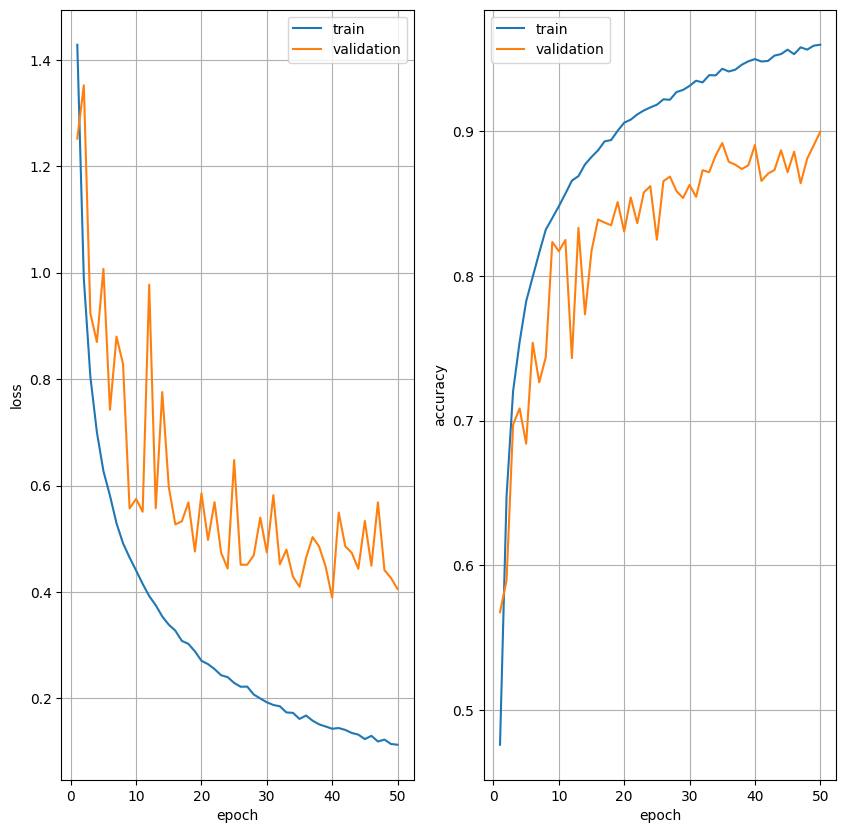

In [18]:
plot_history(history)

In [19]:
test_loss, test_acc = model.evaluate(test_ds)

157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - acc: 0.8865 - loss: 0.4161


### Growth rate, k = 12, bottleneck, dropout, data_aug(pipeline-based), 0.9M parameters - 89.54%


In [20]:
GROWTH_RATE = 12
COMPRESSION_FACTOR = 0.5
DROPOUT_RATE = 0.2

# Define model architecture
in_layer = tf.keras.layers.Input(shape=(32, 32, 3))  # input layer
x = tf.keras.layers.Rescaling(1.0 / 255)(in_layer)  # normalization layer

b = tf.keras.layers.Conv2D(12, kernel_size=(3, 3), padding="same")(x)

b = DenseBlock(6, GROWTH_RATE, bottleneck=True)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(12, GROWTH_RATE, bottleneck=True)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(24, GROWTH_RATE, bottleneck=True)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(12, GROWTH_RATE, bottleneck=True)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = tf.keras.layers.GlobalAveragePooling2D()(b)  # Global Average Pooling
out_layer = tf.keras.layers.Dense(10, activation="softmax")(b)

# Build model
model = tf.keras.Model(inputs=in_layer, outputs=out_layer)

model.summary()

# Compile model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"])

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_93 (Conv2D)                   │ (None, 32, 32, 12)          │             336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_7 (DenseBlock)           │ (None, 32, 32, 84)          │          45,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32, 32, 84)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_7 (TransitionLayer) │ (None, 16, 16, 42)          │           3,906 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_8 (DenseBlock)           │ (None, 16, 16, 186)         │         129,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 16, 16, 186)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_8 (TransitionLayer) │ (None, 8, 8, 93)            │          18,135 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_9 (DenseBlock)           │ (None, 8, 8, 381)           │         401,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 8, 8, 381)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_9 (TransitionLayer) │ (None, 4, 4, 190)           │          74,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_10 (DenseBlock)          │ (None, 4, 4, 334)           │         214,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 4, 4, 334)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_10                  │ (None, 2, 2, 167)           │          57,281 │
│ (TransitionLayer)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 167)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,680 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 947,226 (3.61 MB)

 Trainable params: 934,888 (3.57 MB)

 Non-trainable params: 12,338 (48.20 KB)

In [21]:
# Train model
history = model.fit(
    train_ds,
    epochs=100,
    batch_size=64,
    validation_data=val_ds,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
)

Epoch 1/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 261s 187ms/step - acc: 0.3629 - loss: 1.7207 - val_acc: 0.5012 - val_loss: 1.4524
Epoch 2/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 66s 80ms/step - acc: 0.6131 - loss: 1.0841 - val_acc: 0.6026 - val_loss: 1.1830
Epoch 3/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 81s 79ms/step - acc: 0.7107 - loss: 0.8253 - val_acc: 0.6536 - val_loss: 1.1236
Epoch 4/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 55s 78ms/step - acc: 0.7587 - loss: 0.6942 - val_acc: 0.6900 - val_loss: 0.9271
Epoch 5/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 53s 75ms/step - acc: 0.7891 - loss: 0.6117 - val_acc: 0.7416 - val_loss: 0.8197
Epoch 6/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 54s 76ms/step - acc: 0.8088 - loss: 0.5565 - val_acc: 0.7508 - val_loss: 0.7792
Epoch 7/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 56s 79ms/step - acc: 0.8263 - loss: 0.5057 - val_acc: 0.7576 - val_loss: 0.7912
Epoch 8/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 81s 77ms/step - acc: 0.8394 - loss: 0.4655 - val_acc: 0.7410 - val_loss: 0.8198
Epoch 9/100
704/704 ━━━━━━━━━━

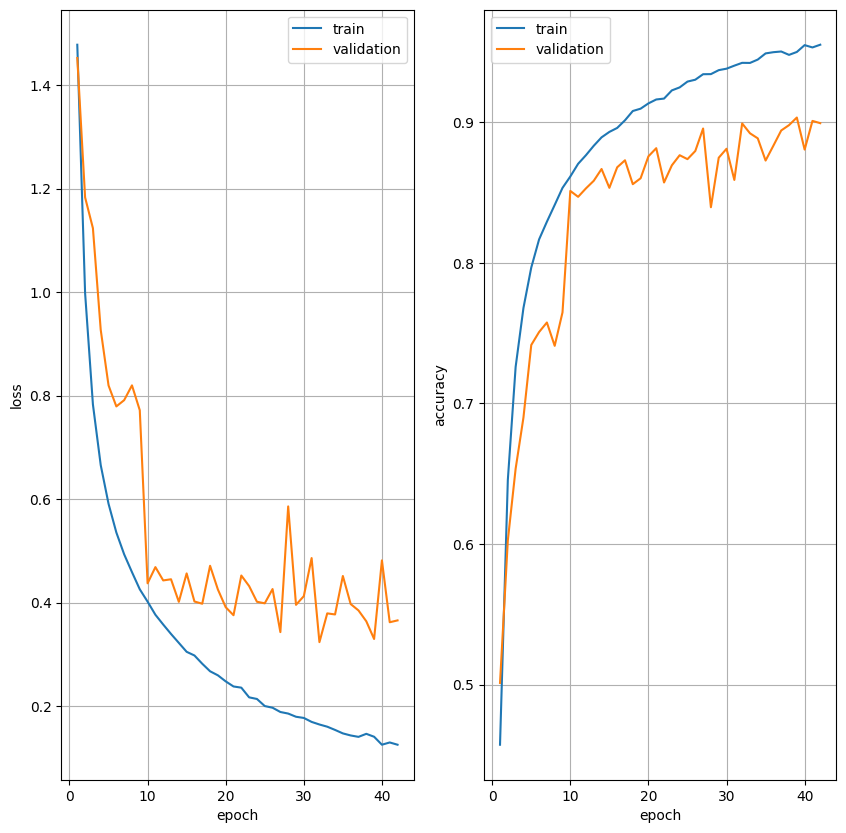

In [22]:
plot_history(history)

In [23]:
test_loss, test_acc = model.evaluate(test_ds)

157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - acc: 0.8954 - loss: 0.3467


### Growth rate, k = 12, bottleneck, dropout, SGD(lr_scheduler) data_aug(pipeline-based), 0.9M parameters - 89.27%


In [24]:
GROWTH_RATE = 12
COMPRESSION_FACTOR = 0.5
DROPOUT_RATE = 0.2
EPOCHS = 100

# Learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.1,
    decay_steps=EPOCHS * len(train_ds),
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

# Define model architecture
in_layer = tf.keras.layers.Input(shape=(32, 32, 3))  # input layer
x = tf.keras.layers.Rescaling(1.0 / 255)(in_layer)  # normalization layer

b = tf.keras.layers.Conv2D(12, kernel_size=(3, 3), padding="same")(x)

b = DenseBlock(6, GROWTH_RATE, bottleneck=True)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(12, GROWTH_RATE, bottleneck=True)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(24, GROWTH_RATE, bottleneck=True)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(12, GROWTH_RATE, bottleneck=True)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = tf.keras.layers.GlobalAveragePooling2D()(b)  # Global Average Pooling
out_layer = tf.keras.layers.Dense(10, activation="softmax")(b)

# Build model
model = tf.keras.Model(inputs=in_layer, outputs=out_layer)

model.summary()

# Compile model
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["acc"]
)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_3 (Rescaling)              │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_206 (Conv2D)                  │ (None, 32, 32, 12)          │             336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_11 (DenseBlock)          │ (None, 32, 32, 84)          │          45,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 32, 32, 84)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_11                  │ (None, 16, 16, 42)          │           3,906 │
│ (TransitionLayer)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_12 (DenseBlock)          │ (None, 16, 16, 186)         │         129,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 16, 16, 186)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_12                  │ (None, 8, 8, 93)            │          18,135 │
│ (TransitionLayer)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_13 (DenseBlock)          │ (None, 8, 8, 381)           │         401,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 8, 8, 381)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_13                  │ (None, 4, 4, 190)           │          74,104 │
│ (TransitionLayer)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_14 (DenseBlock)          │ (None, 4, 4, 334)           │         214,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 4, 4, 334)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_14                  │ (None, 2, 2, 167)           │          57,281 │
│ (TransitionLayer)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 167)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,680 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 947,226 (3.61 MB)

 Trainable params: 934,888 (3.57 MB)

 Non-trainable params: 12,338 (48.20 KB)

In [25]:
# Train model
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=64,
    validation_data=val_ds,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
)

Epoch 1/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 182s 146ms/step - acc: 0.3034 - loss: 1.9018 - val_acc: 0.3678 - val_loss: 2.0353
Epoch 2/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 109s 71ms/step - acc: 0.5104 - loss: 1.3579 - val_acc: 0.3880 - val_loss: 2.0008
Epoch 3/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 50s 71ms/step - acc: 0.6166 - loss: 1.0821 - val_acc: 0.5118 - val_loss: 1.6395
Epoch 4/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 82s 70ms/step - acc: 0.6937 - loss: 0.8803 - val_acc: 0.6718 - val_loss: 1.0152
Epoch 5/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 79s 67ms/step - acc: 0.7421 - loss: 0.7383 - val_acc: 0.7440 - val_loss: 0.7735
Epoch 6/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 84s 69ms/step - acc: 0.7722 - loss: 0.6592 - val_acc: 0.7602 - val_loss: 0.7157
Epoch 7/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 81s 68ms/step - acc: 0.7970 - loss: 0.5974 - val_acc: 0.7996 - val_loss: 0.5809
Epoch 8/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 49s 69ms/step - acc: 0.8108 - loss: 0.5567 - val_acc: 0.7546 - val_loss: 0.7793
Epoch 9/100
704/704 ━━━━━━━━━

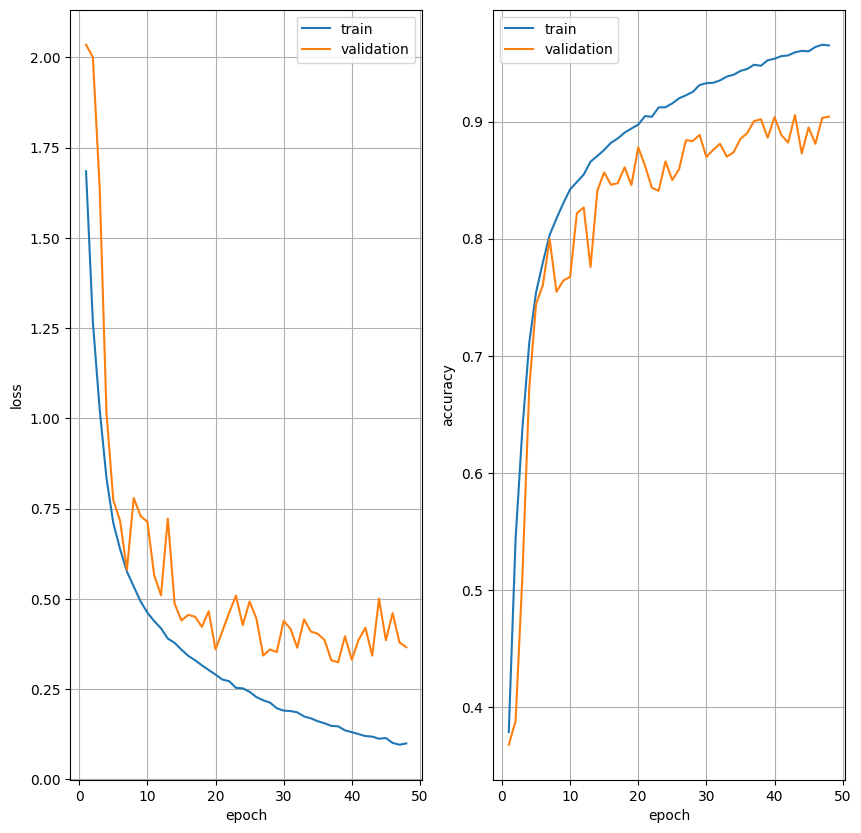

In [26]:
plot_history(history)

In [27]:
test_loss, test_acc = model.evaluate(test_ds)

157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - acc: 0.8927 - loss: 0.3791


## Putting it together


### Growth rate, k = 36, dropout, SGD(lr_scheduler) data_aug(pipeline-based), 0.9M parameters - 87.75%


In [28]:
GROWTH_RATE = 36
COMPRESSION_FACTOR = 0.5
DROPOUT_RATE = 0.2
EPOCHS = 100

# Learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.1,
    decay_steps=EPOCHS * len(train_ds),
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

# Define model architecture
in_layer = tf.keras.layers.Input(shape=(32, 32, 3))  # input layer
x = tf.keras.layers.Rescaling(1.0 / 255)(in_layer)  # normalization layer

b = tf.keras.layers.Conv2D(12, kernel_size=(3, 3), padding="same")(x)

b = DenseBlock(4, GROWTH_RATE)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(4, GROWTH_RATE)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(8, GROWTH_RATE)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(8, GROWTH_RATE)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = tf.keras.layers.GlobalAveragePooling2D()(b)  # Global Average Pooling
out_layer = tf.keras.layers.Dense(10, activation="softmax")(b)

# Build model
model = tf.keras.Model(inputs=in_layer, outputs=out_layer)

model.summary()

# Compile model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"])

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_4 (Rescaling)              │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_319 (Conv2D)                  │ (None, 32, 32, 12)          │             336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_15 (DenseBlock)          │ (None, 32, 32, 156)         │          86,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 32, 32, 156)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_15                  │ (None, 16, 16, 78)          │          12,870 │
│ (TransitionLayer)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_16 (DenseBlock)          │ (None, 16, 16, 222)         │         173,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 16, 16, 222)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_16                  │ (None, 8, 8, 111)           │          25,641 │
│ (TransitionLayer)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_17 (DenseBlock)          │ (None, 8, 8, 399)           │         622,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 8, 8, 399)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_17                  │ (None, 4, 4, 199)           │          81,196 │
│ (TransitionLayer)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_18 (DenseBlock)          │ (None, 4, 4, 487)           │         853,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 4, 4, 487)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_18                  │ (None, 2, 2, 243)           │         120,532 │
│ (TransitionLayer)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 243)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           2,440 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,978,343 (7.55 MB)

 Trainable params: 1,965,239 (7.50 MB)

 Non-trainable params: 13,104 (51.19 KB)

In [29]:
# Train model
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=64,
    validation_data=val_ds,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
)

Epoch 1/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 114s 94ms/step - acc: 0.3940 - loss: 1.6616 - val_acc: 0.4196 - val_loss: 2.1054
Epoch 2/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 83s 51ms/step - acc: 0.6381 - loss: 1.0048 - val_acc: 0.6356 - val_loss: 1.1595
Epoch 3/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 36s 51ms/step - acc: 0.7201 - loss: 0.8002 - val_acc: 0.6098 - val_loss: 1.3248
Epoch 4/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - acc: 0.7613 - loss: 0.6944 - val_acc: 0.7204 - val_loss: 0.9137
Epoch 5/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - acc: 0.7861 - loss: 0.6093 - val_acc: 0.7550 - val_loss: 0.7903
Epoch 6/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - acc: 0.8084 - loss: 0.5619 - val_acc: 0.7062 - val_loss: 1.0019
Epoch 7/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - acc: 0.8215 - loss: 0.5188 - val_acc: 0.7968 - val_loss: 0.6757
Epoch 8/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - acc: 0.8300 - loss: 0.4963 - val_acc: 0.8262 - val_loss: 0.5177
Epoch 9/100
704/704 ━━━━━━━━━━━

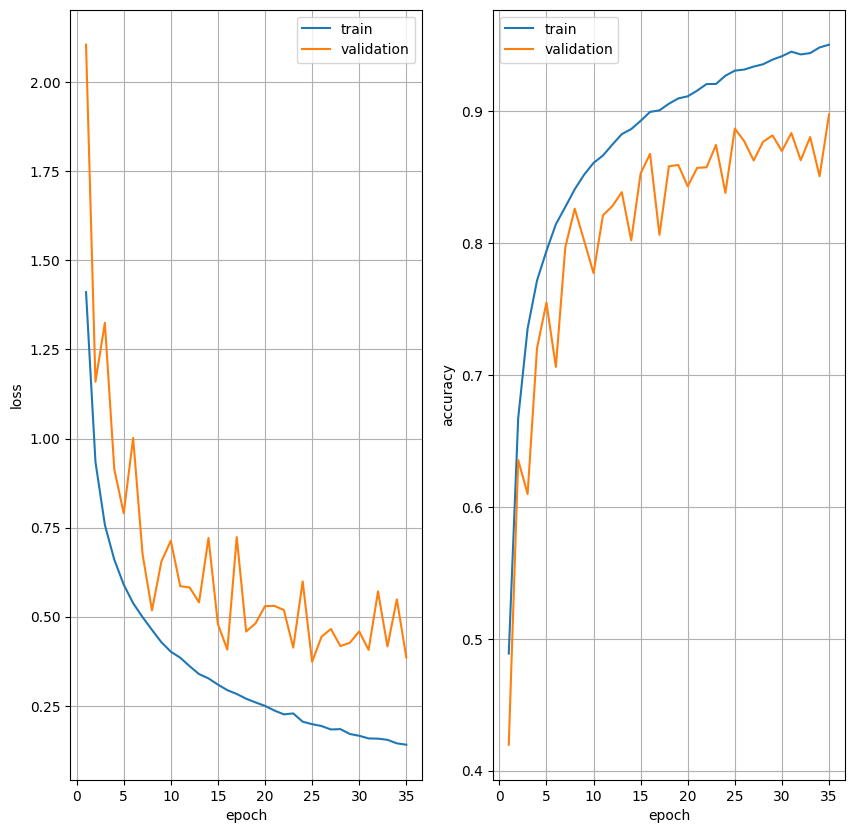

In [30]:
plot_history(history)

In [31]:
test_loss, test_acc = model.evaluate(test_ds)

157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - acc: 0.8775 - loss: 0.4383


### Growth rate, k = 36, bottleneck, dropout, SGD(lr_scheduler) data_aug(pipeline-based), 8.2M parameters - 89.57%

In [32]:
GROWTH_RATE = 36
COMPRESSION_FACTOR = 0.5
DROPOUT_RATE = 0.2
EPOCHS = 100

# Learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.1,
    decay_steps=EPOCHS * len(train_ds),
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

# Define model architecture
in_layer = tf.keras.layers.Input(shape=(32, 32, 3))  # input layer
x = tf.keras.layers.Rescaling(1.0 / 255)(in_layer)  # normalization layer

b = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same")(x)

b = DenseBlock(6, GROWTH_RATE, bottleneck=True)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(12, GROWTH_RATE, bottleneck=True)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(12, GROWTH_RATE, bottleneck=True)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(12, GROWTH_RATE, bottleneck=True)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = tf.keras.layers.GlobalAveragePooling2D()(b)  # Global Average Pooling
out_layer = tf.keras.layers.Dense(10, activation="softmax")(b)

# Build model
model = tf.keras.Model(inputs=in_layer, outputs=out_layer)

model.summary()

# Compile model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"])

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_5 (Rescaling)              │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_348 (Conv2D)                  │ (None, 32, 32, 12)          │             336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_19 (DenseBlock)          │ (None, 32, 32, 228)         │         376,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 32, 32, 228)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_19                  │ (None, 16, 16, 114)         │          27,018 │
│ (TransitionLayer)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_20 (DenseBlock)          │ (None, 16, 16, 546)         │       1,114,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 16, 16, 546)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_20                  │ (None, 8, 8, 273)           │         151,515 │
│ (TransitionLayer)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_21 (DenseBlock)          │ (None, 8, 8, 1137)          │       3,525,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 8, 8, 1137)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_21                  │ (None, 4, 4, 568)           │         650,932 │
│ (TransitionLayer)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_block_22 (DenseBlock)          │ (None, 4, 4, 1000)          │       1,899,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 4, 4, 1000)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transition_layer_22                  │ (None, 2, 2, 500)           │         504,500 │
│ (TransitionLayer)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 500)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           5,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,255,847 (31.49 MB)

 Trainable params: 8,218,921 (31.35 MB)

 Non-trainable params: 36,926 (144.24 KB)

In [33]:
# Train model
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=64,
    validation_data=val_ds,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
)

Epoch 1/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 356s 318ms/step - acc: 0.3397 - loss: 1.9187 - val_acc: 0.4718 - val_loss: 1.7260
Epoch 2/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 183s 214ms/step - acc: 0.5877 - loss: 1.1569 - val_acc: 0.4850 - val_loss: 1.6862
Epoch 3/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 203s 215ms/step - acc: 0.7039 - loss: 0.8483 - val_acc: 0.6042 - val_loss: 1.3195
Epoch 4/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 202s 216ms/step - acc: 0.7611 - loss: 0.6892 - val_acc: 0.6304 - val_loss: 1.4232
Epoch 5/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 201s 215ms/step - acc: 0.7986 - loss: 0.5895 - val_acc: 0.7694 - val_loss: 0.6889
Epoch 6/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 202s 216ms/step - acc: 0.8262 - loss: 0.5141 - val_acc: 0.7706 - val_loss: 0.7268
Epoch 7/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 202s 216ms/step - acc: 0.8389 - loss: 0.4800 - val_acc: 0.7680 - val_loss: 0.7305
Epoch 8/100
704/704 ━━━━━━━━━━━━━━━━━━━━ 202s 215ms/step - acc: 0.8499 - loss: 0.4429 - val_acc: 0.8108 - val_loss: 0.6088
Epoch 9/100
704/


157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - acc: 0.8957 - loss: 0.4001


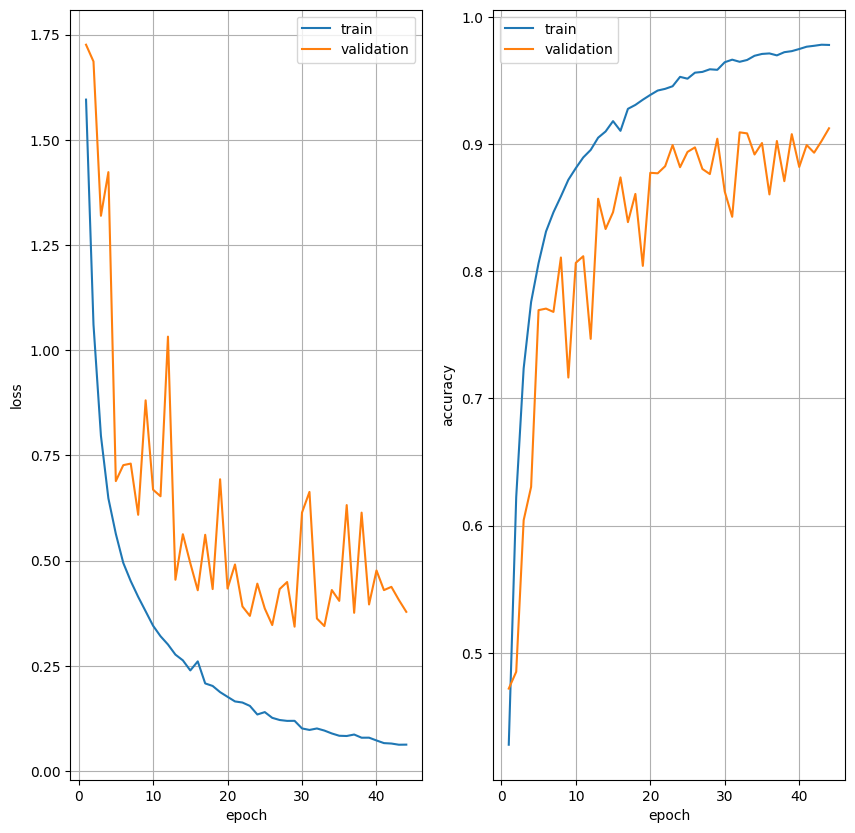

In [34]:
plot_history(history)
print()
test_loss, test_acc = model.evaluate(test_ds)

## Contest model

### Growth rate, k = 24, bottleneck, dropout, SGD(lr_scheduler) data_aug(pipeline-based), 8.2M parameters -

In [ ]:
GROWTH_RATE = 24
COMPRESSION_FACTOR = 0.5
DROPOUT_RATE = 0.2

data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    ]
)

# Learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.1,
    decay_steps=EPOCHS * len(train_ds),
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

# Define model architecture
in_layer = tf.keras.layers.Input(shape=(32, 32, 3))  # input layer
x = tf.keras.layers.Rescaling(1.0 / 255)(in_layer)  # normalization layer

# x = data_augmentation(x)  # data augmentation

b = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same")(x)

b = DenseBlock(6, GROWTH_RATE, bottleneck=True)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(12, GROWTH_RATE, bottleneck=True)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = DenseBlock(24, GROWTH_RATE, bottleneck=True)(b)
b = tf.keras.layers.Dropout(DROPOUT_RATE)(b)
b = TransitionLayer(compression_factor=COMPRESSION_FACTOR)(b)

b = tf.keras.layers.GlobalAveragePooling2D()(b)  # Global Average Pooling
out_layer = tf.keras.layers.Dense(10, activation="softmax")(b)

# Build model
model = tf.keras.Model(inputs=in_layer, outputs=out_layer)

model.summary()

# Compile model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"])

In [ ]:
# Train model
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=64,
    validation_data=val_ds,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=25, restore_best_weights=True),
)

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)

In [ ]:
plot_history(history)